<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/fyp_front_end_implementation_cuda_error_handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/GCC_GT"

ls: cannot access '/content/gdrive/MyDrive/GCC_GT': No such file or directory


In [ ]:
import os
#from tensorflow.keras.preprocessing import image
import numpy as np
import scipy
from scipy.io import loadmat
import glob
import h5py
import time
import joblib
from joblib import Parallel, delayed
import sys
import scipy.spatial

<h2> test the image and ground trueth <h2>

In [ ]:
img_path = "/content/gdrive/MyDrive/GCC_GT/pngs/1532367670.png"

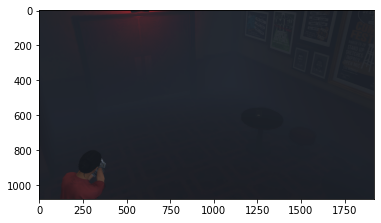

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

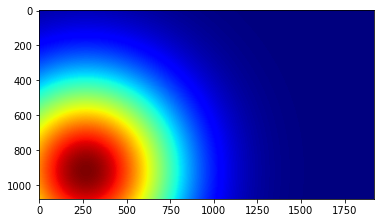

In [ ]:
density_map_path = "/content/gdrive/MyDrive/GCC_GT/GT/1532367670.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
round(np.sum(groundtruth))

1

# New Model Development

In [ ]:
import torch
torch.__version__

'1.9.0+cu102'

In [ ]:
!pip install torch==1.5.0 torchvision==0.6.0

     |████████████████████████████████| 752.0 MB 10 kB/s 
     |████████████████████████████████| 6.6 MB 16.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0 which is incompatible.


In [12]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [ ]:
#create_training_image_list("/content/gdrive/MyDrive/GCC_GT/")
#get_train_val_list("/content/gdrive/MyDrive/GCC_GT/")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [46]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    gt_path = img_path.replace('.png','.h5').replace('pngs','GT')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])

    target = cv2.resize(target,(int(target.shape[1]/36), int(target.shape[0]/36)),interpolation = cv2.INTER_CUBIC)*64
    return img,target
"""
create a list of file (full directory)
"""

def create_training_image_list(data_path):
    """
    create a list of absolutely path of jpg file
    :param data_path: must contain subfolder "images" with *.jpg  (example ShanghaiTech/part_A/train_data/)
    :return:
    """
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "pngs", "*.png"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "pngs", "*.png"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val



class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883
        if self.transform is not None:
            img = self.transform(img)
        return img,target


        
class TestNet(nn.Module):
    def __init__(self, pretrained=False):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        """self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(512 + 512, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(256 + 256 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(128 + 128, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(64 + 64, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) """

        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        """x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x"""


        x_out = self.backend(x5)
        density_map_out = self.output_layer(x_out)
        return density_map_out
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)  


In [14]:
model = TestNet()
model = model.cuda()
model.train()

TestNet(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (features2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (features3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, pa

In [47]:
train_list, val_list = get_train_val_list("/content/gdrive/MyDrive/GCC_GT/")
train_loader = torch.utils.data.DataLoader(ListDataset(train_list,
                                                                shuffle=True,
                                                                transform=transforms.Compose([
                                                                    transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                train=True,
                                                                batch_size=1,
                                                                num_workers=1),batch_size=1)
len(train_loader) # [0.485, 0.456, 0.406] , [0.229, 0.224, 0.225]

train size  27
val size  3


27

In [16]:
epoch = 20
lr = 1e-7
criterion = nn.MSELoss(size_average=False).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=0.95,
                                weight_decay=5 * 1e-4)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
print(model.parameters())

<generator object Module.parameters at 0x7fb4ef2869d0>


In [64]:
import torch, gc
#with torch.no_grad():
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    6284 MB |    7275 MB |  257392 MB |  251108 MB |\n|       from large pool |    6277 MB |    7267 MB |  256879 MB |  250601 MB |\n|       from small pool |       6 MB |      10 MB |     513 MB |     506 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    6284 MB |    7275 MB |  257392 MB |  251108 MB |\n|       from large pool |    6277 MB |    7267 MB |

In [28]:
train, val = train_loader.dataset[0]

torch.Size([3, 480, 853])

In [37]:

c = 0
for i , (img, target) in enumerate(train_loader):
  img = img.cuda()
  c = c + 1
  output = model(img.cuda())
print(c)

27


In [62]:
import torch, gc
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    7274 MB |    7275 MB |  257392 MB |  250117 MB |\n|       from large pool |    7267 MB |    7267 MB |  256879 MB |  249612 MB |\n|       from small pool |       7 MB |      10 MB |     513 MB |     505 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    7274 MB |    7275 MB |  257392 MB |  250117 MB |\n|       from large pool |    7267 MB |    7267 MB |

In [48]:
for epoch in range(0,1):
    mae_train = 0
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        #print(len(img))
        print(i)
        img = Variable(img)
        torch.cuda.memory_summary(device=None, abbreviated=False)
        print(img.shape)
        output = model(img)

        print(output.shape)
        #target = target.type(torch.FloatTensor).unsqueeze(0).cuda()
        target = target.type(torch.FloatTensor).unsqueeze(0).cuda()

        target = Variable(target)

        print(target.shape)
        loss = criterion(output, target)

        #losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch_time.update(time.time() - end)
        #end = time.time()
        #print(i)
        mae_train += abs(output.data.sum() - target.sum().type(torch.FloatTensor).cuda())
        if i % 10 == 0:
            print('Epoch : {}, train loss : {}'.format(epoch, loss))
    mae_train = mae_train/len(train_loader)
    print(' * TRAINING MAE {mae_train:.3f} '.format(mae_train=mae_train))

    """print('begin test')
    test_loader = torch.utils.data.DataLoader(
            ListDataset(val_list,
                                shuffle=False,
                                transform=transforms.Compose([
                                    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225]),
                                ]), train=False),
            batch_size=1)

    model.eval()
    mae = 0

    for i, (img, target) in enumerate(test_loader):
        img = img.cuda()
        img = Variable(img)   
        output = model(img)

        mae += abs(output.data.sum() - target.sum().type(torch.FloatTensor).cuda())

    mae = mae / len(test_loader)
    print(' * TESTING MAE {mae:.3f} '.format(mae=mae))"""

0
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
Epoch : 0, train loss : 16.31578826904297
1
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
2
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
3
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
4
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
5
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
6
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
7
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
8
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
9
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
10
torch.Size([1, 3, 480, 853])
torch.Size([1, 1, 30, 53])
torch.Size([1, 1, 30, 53])
Epoch : 0, train loss 

## model prediction testing

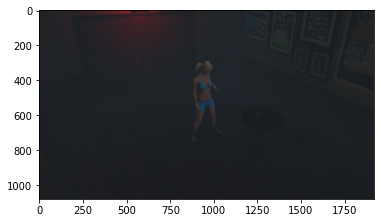

In [49]:
img_path = "/content/gdrive/MyDrive/GCC_GT/pngs/1532367685.png"
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

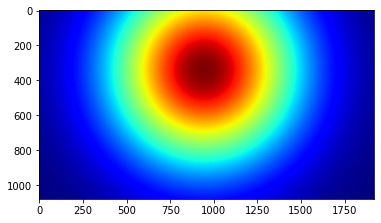

In [50]:

density_map_path = "/content/gdrive/MyDrive/GCC_GT/GT/1532367685.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [51]:
round(np.sum(groundtruth))

1

In [52]:
im = Image.open(img_path)

In [53]:
pred_transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225]),])

In [54]:
pred = model(pred_transform(im)[None].cuda())

In [55]:
pred

tensor([[[[-0.1007, -0.1050, -0.0799,  ..., -0.0777, -0.0800, -0.0817],
          [-0.1143, -0.0965, -0.0780,  ..., -0.0721, -0.0812, -0.0679],
          [-0.0816, -0.0911, -0.0595,  ..., -0.0532, -0.0680, -0.0836],
          ...,
          [-0.0870, -0.0760, -0.0503,  ..., -0.0508, -0.0591, -0.0801],
          [-0.0925, -0.0711, -0.0618,  ..., -0.0692, -0.0642, -0.0804],
          [-0.0926, -0.0920, -0.0691,  ..., -0.1022, -0.0517, -0.0803]]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [56]:
pred[0][0]

tensor([[-0.1007, -0.1050, -0.0799,  ..., -0.0777, -0.0800, -0.0817],
        [-0.1143, -0.0965, -0.0780,  ..., -0.0721, -0.0812, -0.0679],
        [-0.0816, -0.0911, -0.0595,  ..., -0.0532, -0.0680, -0.0836],
        ...,
        [-0.0870, -0.0760, -0.0503,  ..., -0.0508, -0.0591, -0.0801],
        [-0.0925, -0.0711, -0.0618,  ..., -0.0692, -0.0642, -0.0804],
        [-0.0926, -0.0920, -0.0691,  ..., -0.1022, -0.0517, -0.0803]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [57]:
pred = pred.cpu()

In [58]:
pred = pred.detach().numpy()

In [59]:
np.sum(pred)

-648.21185

In [60]:
cv2.imwrite('pred.jpg',pred[0][0])

True

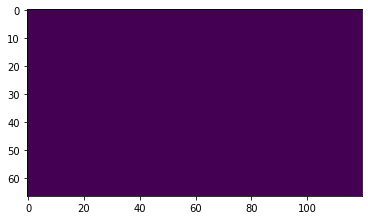

In [61]:
import matplotlib.pyplot as plt
img_path = "./pred.jpg"
im = Image.open(img_path) 
  
plt.imshow(im)